In [1]:
import torch
import cv2
import glob
import pandas as pd
import numpy as np
import os

import random

import config
import utils

from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

Using mps device


To improve the robustness of the CNN model, several data augmentation techniques, including 
- random rotation,
- scaling,
- Gaussian noise transform,
- Gaussian blur transform,
- brightness multiplicative transform and

were applied to increase the sample size.

In [2]:
class CoronarographyDataset(Dataset):
    def __init__(self, dir_path, annotations_file, classes, transforms=None, custom_transforms=None):
        self.dir_path = dir_path
        self.classes = classes
        self.transforms = transforms
        self.custom_transforms = custom_transforms

        # read .csv file with the image annotations
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_annotations = self.img_annotations.sort_values(by=['filename']).reset_index(drop=True)
        # get all the image paths from 'filename' column in sorted order
        self.image_paths = self.img_annotations['filename'].unique()
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]

    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        
        # extract bounding box from annotation file
        bboxes, labels = [], []
        annotations = self.img_annotations[self.img_annotations['filename'] == image_name]
        for idx_i in range(len(annotations)):
            bbox = annotations.iloc[idx_i, 4:].values.astype(int)
            bbox = np.array(bbox, dtype=int)
            bboxes.append(bbox)
            labels.append([1])
        bboxes = np.array(bboxes, dtype=int) 

        # read the image
        image = cv2.imread(image_path)

        # apply custom transforms(resize, remove borders)
        if self.custom_transforms:
            image, bboxes = self.custom_transforms(image, bboxes)

        # bounding box to tensor
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        # no crowd instances
        is_crowd = torch.zeros((bboxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = is_crowd
        target["image_id"] = torch.tensor([idx])

        # apply augmentation
        if self.transforms:
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target

In [3]:
class AlbumentationsCompose(A.Compose):
    def __call__(self, *args, force_apply=False, **data):
        if args:
            msg = "You have to pass data to augmentations as named arguments, for example: aug(image=image)"
            raise KeyError(msg)
        if self.is_check_args:
            self._check_args(**data)

        if not isinstance(force_apply, (bool, int)):
            msg = "force_apply must have bool or int type"
            raise TypeError(msg)

        need_to_run = force_apply or random.random() < self.p

        for p in self.processors.values():
            p.ensure_data_valid(data)
        transforms = self.transforms if need_to_run else get_always_apply(self.transforms)

        check_each_transform = any(
            getattr(item.params, "check_each_transform", False) for item in self.processors.values()
        )
            
        for p in self.processors.values():
            p.preprocess(data)

        data_backup = data.copy()
        for t in transforms:
            # make sure that transformation did not remove bbox
            data = t(**data)
                
            if check_each_transform:
                data = self._check_data_post_transform(data)

            if not len(data['bboxes']):
                data = data_backup.copy()
            data_backup = data.copy()

        data = A.Compose._make_targets_contiguous(data)  # ensure output targets are contiguous

        for p in self.processors.values():
            p.postprocess(data)

        return data

In [4]:
class RemoveBorder(object):
    """
    Cuts black frame of the image. In case of incorrect border detection,
    default values are used to crop the border.
    """
    def __init__(self, max_cut=.2, default_cut=0.2):
        self.max_cut = max_cut
        self.default_cut = default_cut
    
    def __call__(self, image, bboxes):
        # crop borders
        nx, ny, ndx, ndy = utils.cut_frame(image, self.max_cut, self.default_cut)
        nx, ny, ndx, ndy = utils.check_bbox(bboxes, nx, ny, ndx, ndy)
        image_cropped = image[nx:(ndx), ny:(ndy)]

        # calculate new coordinates of bboxes
        bboxes_cropped = []
        for bbox in bboxes:
            x, y, dx, dy = bbox
            bbox_nx, bbox_ny = x - nx, y - ny
            bbox_ndx, bbox_ndy = dx - nx, dy - ny
            bboxes_cropped.append([bbox_nx, bbox_ny, bbox_ndx, bbox_ndy])

        if any(np.array(bboxes_cropped).flatten() < 0):
            print("Negative index of bbox after cropping. Original image was used.")
            return image, bboxes

        return image_cropped, bboxes_cropped


class Resize(object):
    """
    Rescale the image in a sample to a given size. Width and height are kept the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image, bboxes):
        H, W, _ = image.shape
        H_scaled, W_scaled = self.output_size /  H, self.output_size / W
    
        # resize image and bboxes
        image_resized = cv2.resize(image, (self.output_size, self.output_size))
        bboxes_resized = []
        for bbox in bboxes:
            x, y, dx, dy = bbox
            nx = int(np.round(x * W_scaled))
            ny = int(np.round(y * H_scaled))
            ndx = int(np.round(dx * W_scaled))
            ndy = int(np.round(dy * H_scaled))
            bboxes_resized.append([nx, ny, ndx, ndy])
        
        return image_resized, bboxes_resized


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, bboxes):
        for t in self.transforms:
            image, bboxes = t(image, bboxes)
        return image, bboxes


def get_train_custom_transform():
    return Compose([
        RemoveBorder(max_cut=.20, default_cut=0.05),
        Resize(config.RESIZE_TO),
    ])

def get_test_custom_transform():
    return Compose([
        Resize(config.RESIZE_TO),
    ])

def get_train_transform(visualize=False):
    transforms = [
        A.CropAndPad(
            pad_mode=cv2.BORDER_REPLICATE, percent=(0.0, 0.05), 
            sample_independently=True, keep_size=True, p=0.5,
            interpolation=cv2.INTER_CUBIC
        ),
        A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_REFLECT),
        A.GaussNoise(var_limit=(0, 20), p=0.5),
        A.GaussianBlur(p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5
        )
    ]
    if not visualize:
        transforms.append(ToTensorV2(p=1.0))
        
    return AlbumentationsCompose(
        transforms, bbox_params={
        'format': 'pascal_voc', 
        'min_visibility': 0.8,
        'label_fields': ['labels']
    })
    
def get_test_transform(visualize=False):
    transforms = []
    if not visualize:
        transforms.append(ToTensorV2(p=1.0))
    return A.Compose(
        transforms, bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [5]:
def get_train_dataset(visualize=False):
    return CoronarographyDataset(
        dir_path=config.DATASET_DIR, 
        annotations_file=config.TRAIN_ANNOTATION, 
        classes=config.CLASSES,
        custom_transforms=get_train_custom_transform(),
        transforms=get_train_transform(visualize=visualize)
    )

def get_test_dataset(visualize=False):
    return CoronarographyDataset(
        dir_path=config.DATASET_DIR, 
        annotations_file=config.TEST_ANNOTATION, 
        classes=config.CLASSES,
        custom_transforms=get_test_custom_transform(),
        transforms=get_test_transform(visualize=visualize)
    )

In [16]:
def create_train_loader(train_dataset):
    return DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        collate_fn=utils.collate_fn
    )

def create_test_loader(test_dataset):
    return DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        collate_fn=utils.collate_fn
    )

In [22]:
def visualize_dataset(dataset, num_images=9, figsize=(10, 10)):
    cols = 3
    rows = int(np.ceil(num_images / cols))

    fig = plt.figure(figsize=figsize)
    for i in range(num_images):
        try:
            img_idx = np.random.randint(0, len(dataset))
            image, target = dataset[img_idx]
            fig.add_subplot(rows, cols, i+1)
            for box_num in range(len(target['boxes'])):
                box = target['boxes'][box_num]
                label = config.CLASSES[target['labels'][box_num]]
                cv2.rectangle(
                    image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                    (255, 0, 0), 2
                )
                cv2.putText(
                    image, str(img_idx), (410, 30), 
                    cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255)
                )
            plt.imshow(image)
        except Exception as e:
            print(f"Exception with image of index {img_idx}:", e)
    plt.show()

Train set visualziation: 


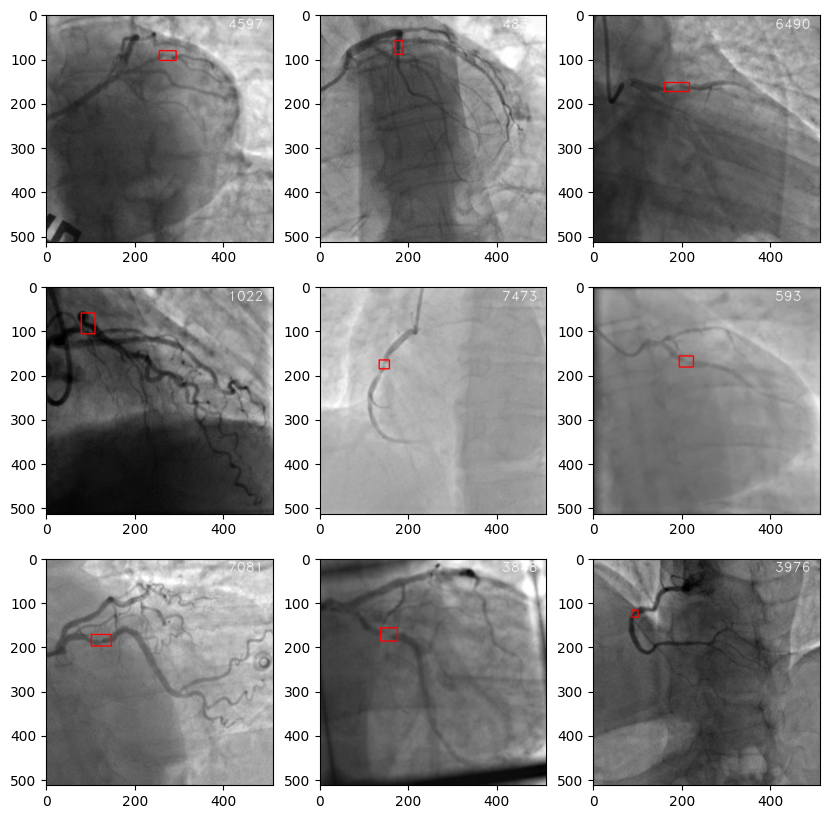

In [26]:
train_visualize_dataset = get_train_dataset(visualize=True)
print("Train set visualziation: ")
visualize_dataset(train_visualize_dataset, config.NUM_SAMPLES_TO_VISUALIZE)

Test set visualization: 


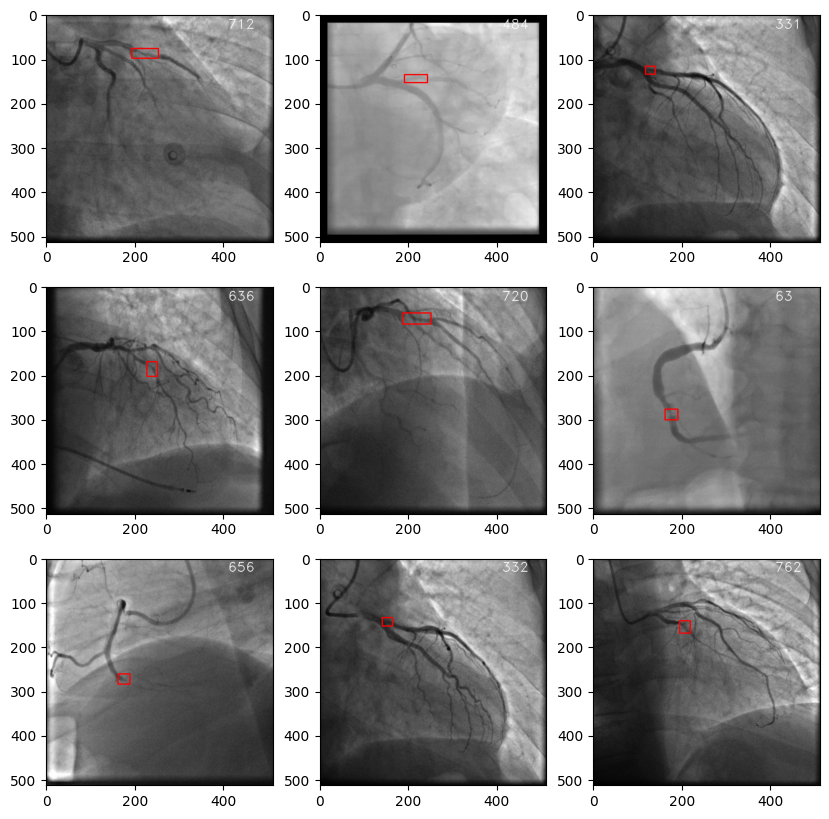

In [25]:
test_visualize_dataset = get_test_dataset(visualize=True)
print("Test set visualization: ")
visualize_dataset(test_visualize_dataset, config.NUM_SAMPLES_TO_VISUALIZE)

In [8]:
train_dataset = get_train_dataset(visualize=False)
test_dataset = get_test_dataset(visualize=False)

In [40]:
[2102, 985]

[2102, 985]

In [13]:
train_dataset = CoronarographyDataset(
    config.DATASET_DIR, 
    config.TRAIN_ANNOTATION, 
    config.CLASSES, 
    custom_transforms = get_train_custom_transform(),
    transforms=get_train_transform()
)

In [ ]:
dataset = CoronarographyDataset(
    config.DATASET_DIR, 
    config.TRAIN_ANNOTATION, 
    config.CLASSES, 
    custom_transforms= Compose([
        Resize(config.RESIZE_TO)
    ])
)

In [ ]:
# dataset[1]

***

In [ ]:
def create_train_dataset():
    train_dataset = CustomDataset(config.DATASET_DIR, config.TRAIN_ANNOTATION, config.RESIZE_TO, config.RESIZE_TO, config.CLASSES, None, utils.custom_transform())
    return train_dataset
    
def create_valid_dataset():
    valid_dataset = CustomDatasetconfig.DATASET_DIR, config.TRAIN_ANNOTATION, config.RESIZE_TO, config.RESIZE_TO, config.CLASSES)
    return valid_dataset

In [ ]:
ds = CoronarographyDataset(config.DATASET_DIR, config.TRAIN_ANNOTATION, config.RESIZE_TO, config.RESIZE_TO, config.CLASSES)

In [ ]:
tmp = ds.img_annotations

In [ ]:
bboxes = []
for idx in tmp[tmp.filename == '14_002_5_0017.bmp'].index:
    bbox = tmp.iloc[idx, 4:].values.astype(int)
    bbox = np.array(bbox, dtype=int)
    bboxes.append(bbox)
bboxes = np.array(bboxes, dtype=int)

In [ ]:
bboxes

In [ ]:
area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])

In [ ]:
area

In [ ]:
torch.zeros((bboxes.shape[0],), dtype=torch.int64)